<a href="https://colab.research.google.com/github/RGivisiez/Adv_ML/blob/master/Adv_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.preprocessing import LabelEncoder
from itertools import product

import xgboost as xgb

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.models import Sequential

Using TensorFlow backend.


In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
path = '/content/gdrive/My Drive/Colab Notebooks/Kaggle Data'

In [11]:
path = '~/Git_repo/Adv_ML/data'

#File descriptions:

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

#Data fields:

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

> [Kaggle Competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

# Loading data

In [12]:
train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')

print('Treino \n', train.head(), '\n')
print('Itens \n', items.head(), '\n')
print('Itens Cat \n', items_cat.head(), '\n')
print('Shops \n', shops.head(), '\n')

Treino 
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0 

Itens 
                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40   

Itens Cat 
 

In [13]:
train_full = pd.merge(train, items, on='item_id', how='left')
train_full = pd.merge(train_full, items_cat, on='item_category_id', how='left')
train_full = pd.merge(train_full, shops, on='shop_id', how='left')

In [14]:
train_full.date=train_full.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [15]:
print('Teste \n', test.tail() )

Teste 
             ID  shop_id  item_id
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969


# EDA

In [0]:
#@title Testando se existe algum NA ou Null
print(train_full.isna().any())
print(train_full.isnull().any())

date                  False
date_block_num        False
shop_id               False
item_id               False
item_price            False
item_cnt_day          False
item_name             False
item_category_id      False
item_category_name    False
shop_name             False
dtype: bool
date                  False
date_block_num        False
shop_id               False
item_id               False
item_price            False
item_cnt_day          False
item_name             False
item_category_id      False
item_category_name    False
shop_name             False
dtype: bool


In [0]:
#@title Train_full Dataset
train_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [0]:
#@title Correlação linear
variable_name = "adsf"
train_full.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402,0.029128
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230,0.019380
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650,0.369431
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197,-0.253554
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000,0.014768
item_category_id,0.029128,0.019380,0.369431,-0.253554,0.014768,1.000000


* **Sem correlação linear**

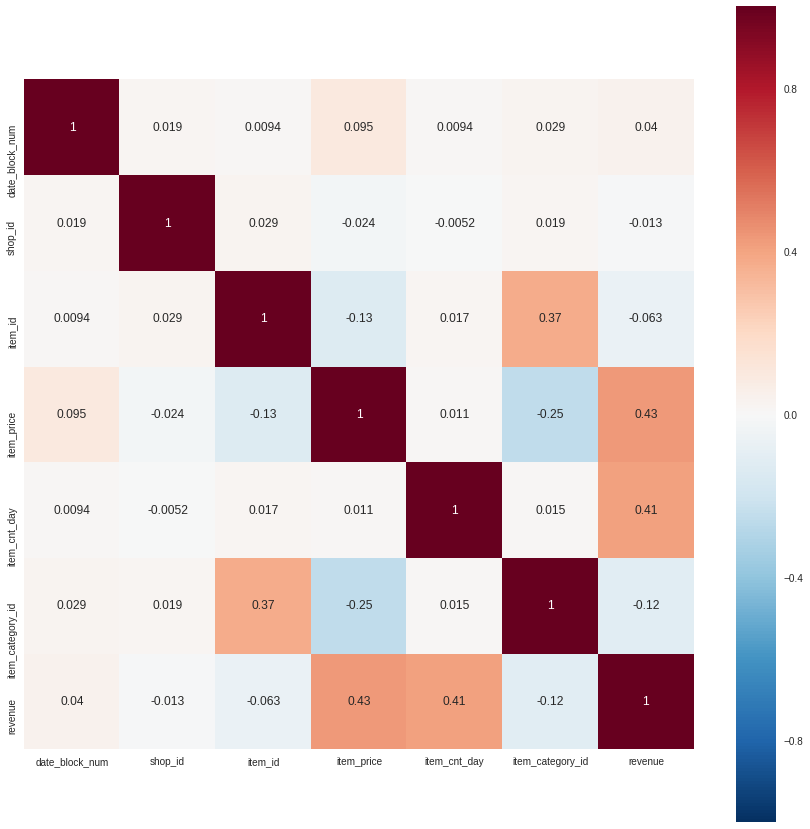

In [0]:
#@title Mapa da correlação entre as features
correlation = train_full.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True)
plt.show()

In [0]:
#@title Estatística geral do Train_full e Test
print(train_full.describe())
print(test.describe())

       date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00   
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

       item_category_id  
count      2.935849e+06  
mean       4.000138e+01  
std        1.710076e+01  
min        0.000000e+00  
25%        2.800000e+01  
50%        4.000000e+01  
75%        5.500000e+01  
max        8.300000e+01  
                  ID        shop_id 

* **Item_price tem um valor mínimo negativo, seu desvio padrão e valor máximo muito elevados.**
* **Valores negativos de Item_cnt_day provavelmente são devoluções.**
* **Tem muito mais itens no Train_full do que no Test**

In [0]:
#@title Itens e shoppings únicos no teste e train_full
print('Test:')
print('- Número de itens únicos:', test['item_id'].nunique())
print('- Número de shoppings únicos:', test['shop_id'].nunique())
print('\n Train_full:')
print('- Número de itens únicos:', train_full['item_id'].nunique())
print('- Número de shoppings únicos:', train_full['shop_id'].nunique())

Test:
- Número de itens únicos: 5100
- Número de shoppings únicos: 42

 Train_full:
- Número de itens únicos: 21807
- Número de shoppings únicos: 60


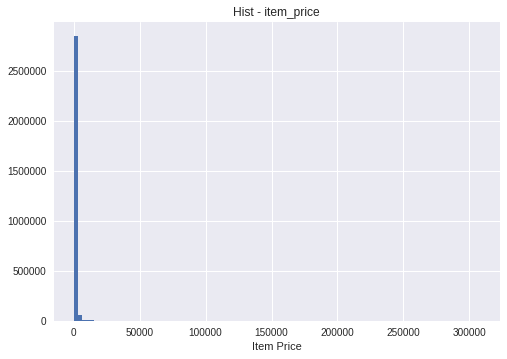

In [0]:
#@title Histogramas
plt.hist(train_full['item_price'], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')
plt.show()


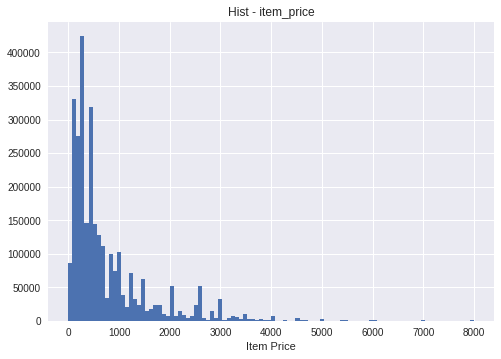

In [0]:
#@title Histogramas preços menores que 8000
plt.hist(train_full['item_price'][train_full.item_price < 8000], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')
plt.show()


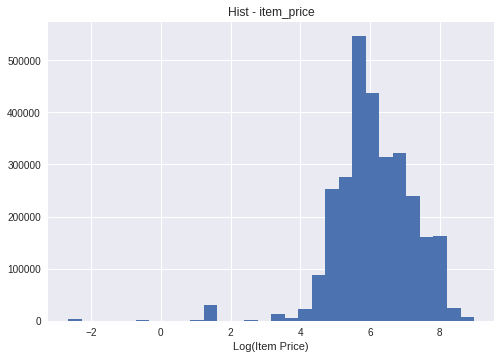

In [0]:
#@title Histogramas do log dos preços menores que 8000
x = train_full['item_price'][train_full.item_price < 8000].values
x = np.log(np.abs(x))
plt.hist(x, bins = 30)
plt.title('Hist - item_price')
plt.xlabel('Log(Item Price)')
plt.show()


* **Alguns produtos tem preços muitos altos (primeiro histograma)**
* **A maioria das vendas são de produtos com preços baixos (segundo histograma)**

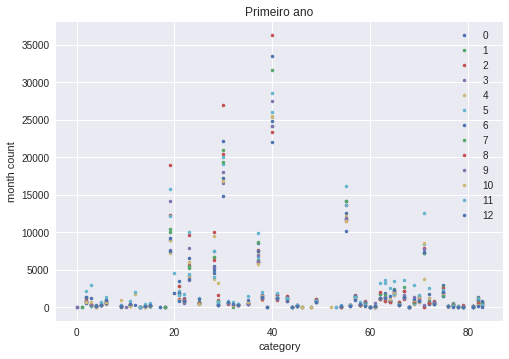

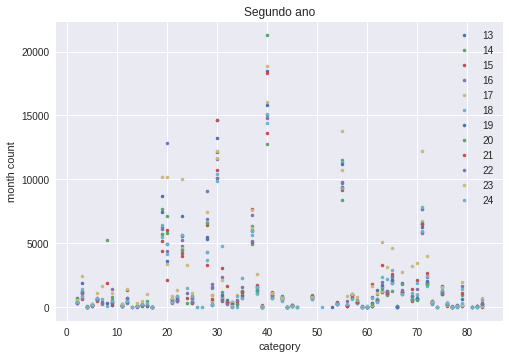

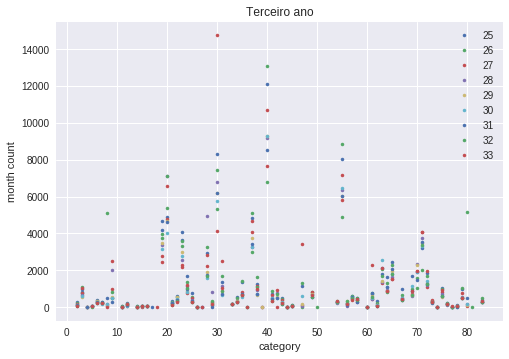

Itens mais vendidos:
Primeiro ano:
[19, 21, 23, 28, 30, 37, 40, 55, 71, 75]
Segundo ano:
[8, 19, 20, 23, 28, 30, 37, 40, 55, 71]
Terceiro ano:
[8, 19, 20, 23, 28, 30, 31, 37, 40, 47, 55, 71, 80]
Set: [37, 71, 40, 8, 75, 47, 80, 19, 23, 21, 20, 55, 28, 30, 31]


In [0]:
#@title Número de itens vendidos por categoria
df = train_full[['date_block_num', 'item_category_id', 'item_cnt_day']].groupby(['date_block_num', 'item_category_id'])
x = df.sum()
plt.figure(1)
for i in range(13):
  plt.plot(x.loc[i],'.', label=i)
  plt.legend()
  
plt.title('Primeiro ano')
plt.xlabel('category')
plt.ylabel('month count')

plt.figure(2)
for i in range(13,25):
  plt.plot(x.loc[i],'.', label=i)
  plt.legend()
  
plt.title('Segundo ano')  
plt.xlabel('category')
plt.ylabel('month count')
  
plt.figure(3)
for i in range(25,34):
  plt.plot(x.loc[i],'.', label=i)
  plt.legend()

plt.title('Terceiro ano')
plt.xlabel('category')
plt.ylabel('month count')

plt.show()

aux = []

item_id = []
for i in range(13):
  item_id += list(x.loc[i].nlargest(n=8,columns=['item_cnt_day']).reset_index()['item_category_id'])

print('Itens mais vendidos:')
print('Primeiro ano:')
print(sorted(set(item_id)))

aux += item_id

item_id = []
for i in range(13,25):
  item_id += list(x.loc[i].nlargest(n=8,columns=['item_cnt_day']).reset_index()['item_category_id'])
print('Segundo ano:')
print(sorted(set(item_id)))

aux += item_id

item_id = []
for i in range(25,34):
  item_id += list(x.loc[i].nlargest(n=8,columns=['item_cnt_day']).reset_index()['item_category_id'])
print('Terceiro ano:')
print(sorted(set(item_id)))

aux += item_id
print('Set:', list(set(aux)))

* **Algumas categorias tem vendas altas independente do mês.**
* ** 19, 23, 28, 30, 37, 40, 55, 71 **

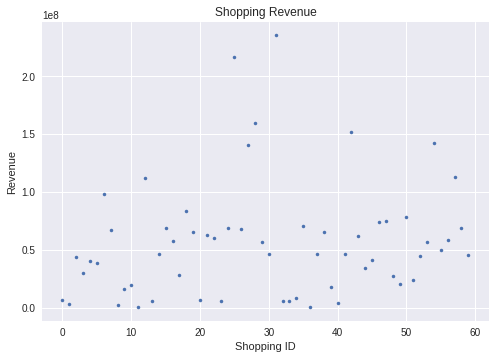

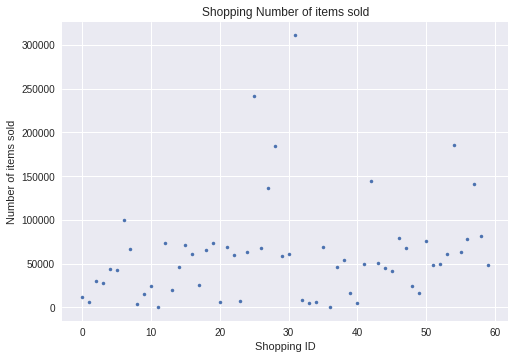

Shoppings com maior receita:
[31, 25, 28, 42, 54, 27, 57, 12]
Shoppings com maior numeror de vendas:
[31, 25, 54, 28, 42, 57, 27, 6]


In [0]:
#@title Vendas totais por shopping
x = train_full[['shop_id','item_cnt_day','item_price','item_category_id']]
x = x.assign(revenue=lambda x:x['item_cnt_day'] * x['item_price'])
shop_data = x.groupby(['shop_id'])
plt.figure(1)
plt.title('Shopping Revenue')
plt.plot(shop_data['revenue'].sum(), '.')
plt.xlabel('Shopping ID')
plt.ylabel('Revenue')

plt.figure(2)
plt.title('Shopping Number of items sold')
plt.plot(shop_data['item_cnt_day'].sum(), '.')
plt.ylabel('Number of items sold')
plt.xlabel('Shopping ID')
plt.show()

print('Shoppings com maior receita:')
print(list(shop_data.sum().nlargest(n=8,columns=['revenue']).reset_index()['shop_id']))
print('Shoppings com maior numeror de vendas:')
print(list(shop_data.sum().nlargest(n=8,columns=['item_cnt_day']).reset_index()['shop_id']))

* **Os shoppings com maior receita vendem uma grande quantidade de itens.**

In [0]:
#@title Os shoppings que vendem mais e as categorias que vendem mais.
x = train_full[['shop_id','item_cnt_day','item_price','item_category_id']]
x = x.assign(revenue=lambda x:x['item_cnt_day'] * x['item_price'])
shop_data = x.groupby(['shop_id','item_category_id'])

y = shop_data.sum()

#ctg_id = [19, 23, 28, 30, 37, 40, 55, 71]
ctg_id = [37, 71, 40, 8, 75, 47, 80, 19, 23, 21, 20, 55, 28, 30, 31]

print('Categorias mais vendidas:', ctg_id)

print('\n: Shopping ID')
print(': Número de categorias mais vendidas no shopping e que estão entre as categorais mais vendidas.')
print(': Renda gerada vendendo essas categorias.\n')

print('\nShoppings com maior rendimento e número de vendas:\n')
for i in [31, 25, 28, 42, 54, 27, 57, 12]:
  a = y.loc[i].nlargest(n=15,columns=['item_cnt_day']).reset_index()
  c = a['item_category_id'].isin(ctg_id) * a['revenue']
  print('Shop_id', i, ' :', a['item_category_id'].isin(ctg_id).sum(), ' :', c.sum())

print('\nShoppings aleatórios:\n')
for i in [10, 35, 20, 5, 45, 29, 59, 47]:
  a = y.loc[i].nlargest(n=15, columns=['item_cnt_day']).reset_index()
  c = a['item_category_id'].isin(ctg_id) * a['revenue']
  print('Shop_id', i, ' :', a['item_category_id'].isin(ctg_id).sum(), ' :', c.sum())
for i in range(6):
  a = y.loc[i].nlargest(n=15, columns=['item_cnt_day']).reset_index()
  c = a['item_category_id'].isin(ctg_id) * a['revenue']
  print('Shop_id', i, ' :', a['item_category_id'].isin(ctg_id).sum(), ' :', c.sum())

Categorias mais vendidas: [37, 71, 40, 8, 75, 47, 80, 19, 23, 21, 20, 55, 28, 30, 31]

: Shopping ID
: Número de categorias mais vendidas no shopping e que estão entre as categorais mais vendidas.
: Renda gerada vendendo essas categorias.


Shoppings com maior rendimento e número de vendas:

Shop_id 31  : 9  : 128964010.55999869
Shop_id 25  : 9  : 112989786.9599998
Shop_id 28  : 9  : 91277665.05000052
Shop_id 42  : 9  : 82462316.41999897
Shop_id 54  : 9  : 74693125.01999907
Shop_id 27  : 9  : 70817043.51999931
Shop_id 57  : 10  : 64832685.72999942
Shop_id 12  : 10  : 44280812.62999961

Shoppings aleatórios:

Shop_id 10  : 11  : 12487899.270000005
Shop_id 35  : 10  : 41507034.84000018
Shop_id 20  : 1  : 400020.00000001973
Shop_id 5  : 9  : 21815869.31999968
Shop_id 45  : 9  : 23999341.13999974
Shop_id 29  : 10  : 35254924.86999988
Shop_id 59  : 11  : 26855611.990000106
Shop_id 47  : 9  : 41867324.120000586
Shop_id 0  : 9  : 4072604.0
Shop_id 1  : 9  : 1936489.0
Shop_id 2  : 11  : 254478

* **Shoppings que vendem mais os produtos 37, 71, 40, 8, 75, 47, 80, 19, 23, 21, 20, 55, 28, 30, 31 possuem maior receita **

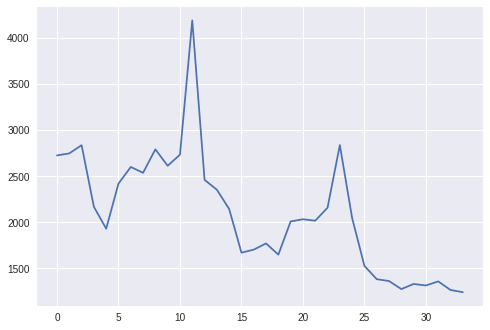

In [0]:
shop_idx = 15
x = train_full[train_full['shop_id'] == shop_idx].iloc[:,1].unique()
y = train_full[train_full['shop_id'] == shop_idx].iloc[:,:].groupby('date_block_num')['item_cnt_day'].sum()
plt.plot(x,y)
plt.show()

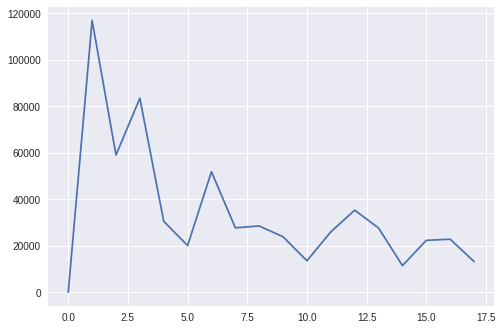

1 / 12
[1.         0.50473499 0.71370429 0.26094443 0.17165609 0.44324734
 0.2369359  0.24373895 0.20382034 0.11567019 0.22209765 0.30178846
 0.2361803  0.09776564 0.19083209 0.19498063 0.1129301 ]


In [0]:
data_fft = np.fft.fft(y-y.mean())
frequencies = np.abs(data_fft)
plt.plot(frequencies[0:int(len(frequencies)/2)+1]*12)
plt.show()
print(np.argmax(frequencies[0:int(len(frequencies)/2)+1]),'/', '12')
print(frequencies[1:int(len(frequencies)/2)+1]/frequencies.max())

# Criando features novas

In [17]:
#@title Cria uma coluna revenue (item_cnt_day*item_price)
train_full['revenue'] = train_full['item_cnt_day'] * train_full['item_price']
train_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,revenue
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",999.00
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",899.00
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",-899.00
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1099.00


In [18]:
#@title Criando city e city_code
train_full.loc[train_full.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
train_full['city'] = train_full['shop_name'].str.split(' ').map(lambda x: x[0])
train_full.loc[train_full.city == '!Якутск', 'city'] = 'Якутск'
train_full['city_code'] = LabelEncoder().fit_transform(train_full['city'])
train_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,revenue,city,city_code
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",999.00,Ярославль,30
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",899.00,Москва,13
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",-899.00,Москва,13
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1709.05,Москва,13
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1099.00,Москва,13


In [19]:
#@title Separando as categorias em tipo e subtipo
train_full['split'] = train_full['item_category_name'].str.split('-')
train_full['type'] = train_full['split'].map(lambda x: x[0].strip())
train_full['type_code'] = LabelEncoder().fit_transform(train_full['type'])

train_full['subtype'] = train_full['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
train_full['subtype_code'] = LabelEncoder().fit_transform(train_full['subtype'])
train_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,revenue,city,city_code,split,type,type_code,subtype,subtype_code
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",999.00,Ярославль,30,"[Кино , Blu, Ray]",Кино,11,Blu,1
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",899.00,Москва,13,"[Музыка , Винил]",Музыка,13,Винил,27
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",-899.00,Москва,13,"[Музыка , Винил]",Музыка,13,Винил,27
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум""",1709.05,Москва,13,"[Музыка , Винил]",Музыка,13,Винил,27
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум""",1099.00,Москва,13,"[Музыка , CD фирменного производства]",Музыка,13,CD фирменного производства,3


In [20]:
#@title Limpando colunas que não são necessárias
train_full.drop(['item_category_name', 'city', 'split', 'type', 'subtype'], axis='columns', inplace=True)
train_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,revenue,city_code,type_code,subtype_code
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",999.00,30,11,1
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",899.00,13,13,27
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",-899.00,13,13,27
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",1709.05,13,13,27
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",1099.00,13,13,3


In [21]:
#@title Dropa as colunas date, item_name, item_category_name, shop_name
train_cleaned = train_full.drop(['item_name', 'shop_name', 'date'], axis=1)
train_cleaned.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,revenue,city_code,type_code,subtype_code
0,0,59,22154,999.00,1.0,37,999.00,30,11,1
1,0,25,2552,899.00,1.0,58,899.00,13,13,27
2,0,25,2552,899.00,-1.0,58,-899.00,13,13,27
3,0,25,2554,1709.05,1.0,58,1709.05,13,13,27
4,0,25,2555,1099.00,1.0,56,1099.00,13,13,3


# kNN

 ** To do: **
   - Knn
   - t-SNE
   - Manifold (tenta generalizar PCA, ICA e LDA)

# Time series analysis (Basic)


Escolhendo um shopping qualquer vamos fazer uma análise da série temporal da sua receita por mês.

** Sobre as séries temporais: **

* É importante garantir que a série temporal é estacionária, ou seja, sua média, variância e covariância não variam com o tempo.
* Uma série estacionária é mais fácil de ser avaliada. (Nada vária)
* A maioria das séries temporais serão não estacionárias.

In [0]:
#@title Importa os pacotes do statsmodels.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
shop_idx = 44 # Vai de [0, 59]

In [0]:
#@title Número de itens vendidos e receita por mês:
shop_month = train_cleaned[train_cleaned.shop_id == shop_idx].drop(['item_price', 'item_category_id', 'shop_id', 'item_id'], axis=1).groupby(['date_block_num']).sum()
shop_month = shop_month.rename(columns={'item_cnt_day':'item_cnt_month'})
shop_month.head()

,item_cnt_month,revenue
date_block_num,,
0,1708.0,913969.0
1,1823.0,1030422.0
2,2131.0,1214500.7
3,1628.0,845157.0
4,1379.0,684877.0


In [0]:
#@title Não precisamos mais do index date_block_num:
month = shop_month.reset_index().drop(['date_block_num'], axis=1)
month.head()

,item_cnt_month,revenue
0,1708.0,913969.0
1,1823.0,1030422.0
2,2131.0,1214500.7
3,1628.0,845157.0
4,1379.0,684877.0


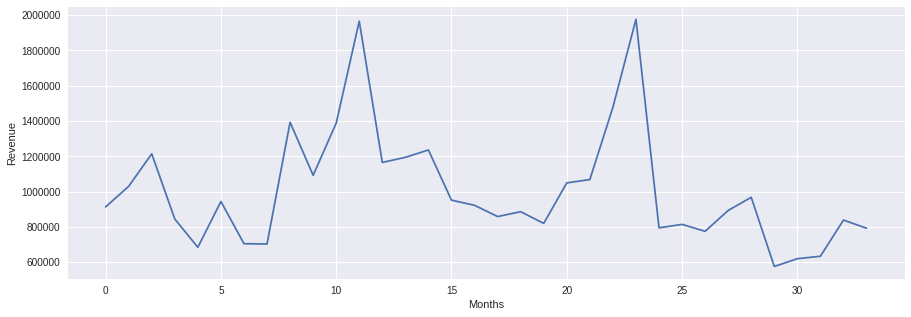

In [0]:
#@title Gráfico da receita por mês:

plt.figure(figsize=(15,5))
plt.plot(month['revenue'])
plt.xlabel('Months')
plt.ylabel('Revenue')
plt.show()

** Analises básicas para séries temporais: ** (Seasonal Decompose)
* ** Trend: ** Mostra a tendência de queda ou subida da série.
* ** Seasonal: ** Indica repetições na série.
* ** Residual: ** O que sobra da série após retirar o Trend e Seasonal.

Essa análise é muito simples, não deve ser usada em coisas importantes.



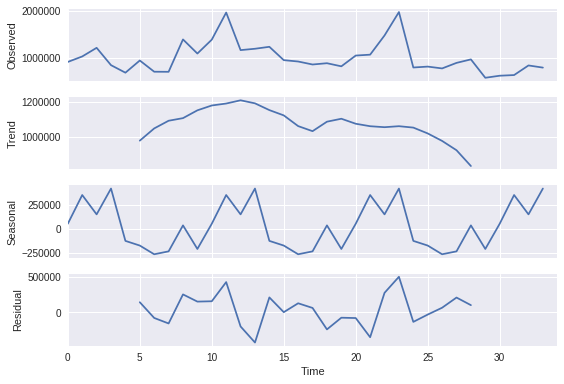

In [0]:
#@title Decomposição simples:
result = seasonal_decompose(month['revenue'].values, freq=10, model='adtive')
result.plot()
plt.show()

** Analises básicas para séries temporais: ** (Rolling Window)
* Rolling window: Cada ponto é gerado tomando a média dos pontos antes e depois. A quantidade de pontos
que serão considerados é dado pela variável win. 
* Podemos subtrair o rolling.mean() de um dataset para tentar retirar alguma tendência.
* Pode ser usado para suavizar a série temporal.

In [0]:
win = 2

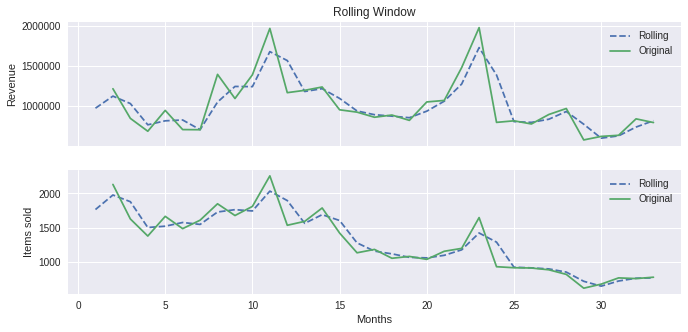

In [0]:
#@title Rolling window:

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(11,5))

ax1.set_title('Rolling Window')

ax1.plot(month['revenue'].rolling(window=win).mean(), linestyle='--', label='Rolling')
ax1.plot(month['revenue'][win:], label='Original')
ax1.set_ylabel('Revenue')
ax1.legend()

ax2.plot(month['item_cnt_month'].rolling(window=win).mean(), linestyle='--', label='Rolling')
ax2.plot(month['item_cnt_month'][win:], label='Original')
ax2.set_ylabel('Items sold')
ax2.set_xlabel('Months')
ax2.legend()

plt.show()

# Time series analysis (ARMA, ARIMA, SARIMA)

* ** É importante remover qualquer tendência e sazonalidade da série temporal. Isso melhorar
o poder preditivo do modelo. **

* Sites para referência: 
 * [Bem completo](https://www.quantstart.com/articles#time-series-analysis)
 * [1](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARIMA)
 * [4](http://people.duke.edu/~rnau/whatuse.htm)
 * [5](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
 
 * [Kernel com ARIMA](https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima)
 * [Kernel com SARIMA](https://www.kaggle.com/leandrovrabelo/climate-change-forecast-sarima-model?utm_medium=email&utm_source=intercom&utm_campaign=datanotes-2019)
 
 
 https://otexts.com/fpp2/non-seasonal-arima.html

** Tirar a diferença entre os pontos $x_t$ e $x_{t+1}$ pode ser suficiente para tirar a tendência da série (detrend). **
* Pandas diff(n) : look at the difference between successive n data points.

In [0]:
dif = 1

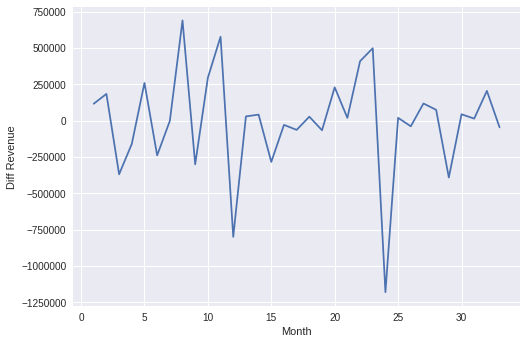

In [0]:
#@title Gráfico da diferença.

figure, ax1 = plt.subplots(1)
ax1.plot(month['revenue'].diff(dif)[dif:])
ax1.set_ylabel('Diff Revenue')
ax1.set_xlabel('Month')

plt.show()

** Para ver se foram removidos as tendências e sazonalidade é necessário olharar para a autocorrelação, se
ela estiver dentro da barra de erro (região azul) então conseguimos remover as tendências e sazonalidade. **
Obs.: É esperado que $5\%$ do pontos estejam próximos ou passando da região.

* Autocorrelation: how a time series relates to its past. 
* Com dif = 6 vemos uma autocorrelação que apresenta ciclos (sazonalidade).
* Com dif = 12 parece que temos uma série descorrelacionada entre si.
* A autocorrelação da receita (sem diff) parece apresentar ciclos (sazonalidade).




In [0]:
dif = 6

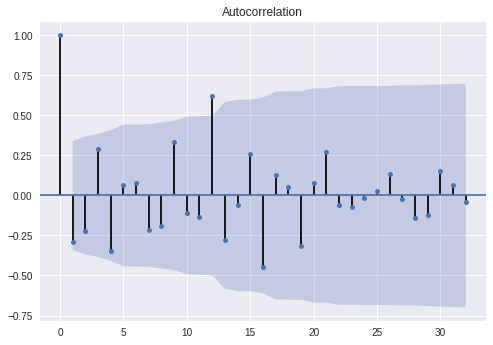

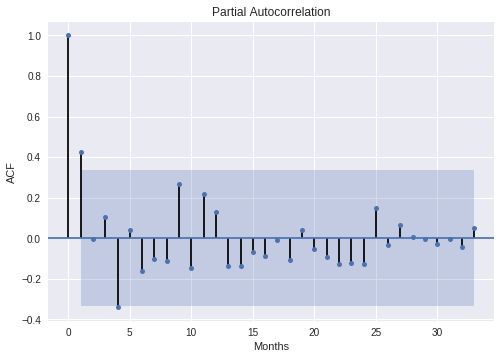

In [0]:
#@title Autocorrelação da diferença:
plot_acf(month['revenue'].diff(dif)[dif:], alpha=0.05, unbiased=True)
plot_pacf(month['revenue'])
plt.xlabel('Months')
plt.ylabel('ACF')
plt.show()


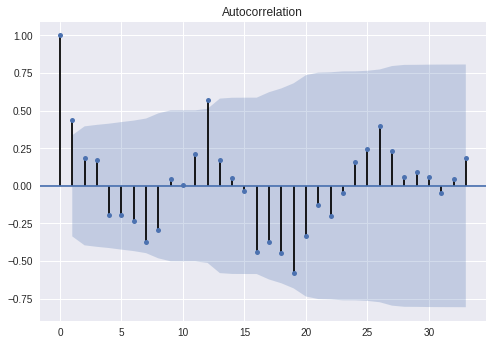

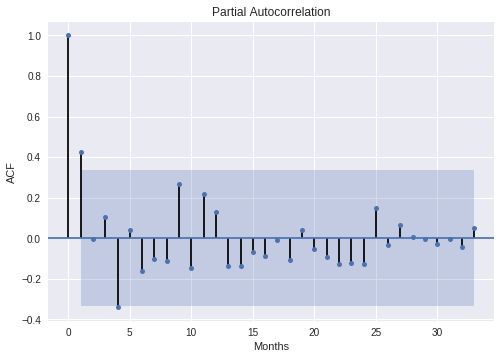

In [0]:
#@title Autocorrelação da receita: (Sem aplicar diff)
plot_acf(month['revenue'], alpha=0.05, unbiased=True)
plot_pacf(month['revenue'])
plt.ylabel('ACF')
plt.xlabel('Months')
plt.show()

In [0]:
#@title Adfuller teste para os dados puros:
adfinput = adfuller(month['revenue'])
adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
adftest = round(adftest,4)
for key, value in adfinput[4].items():
   adftest["Critical Value (%s)"%key] = value.round(4)
print(adftest)

Test Statistic                 -3.4893
p-value                         0.0083
Lags Used                       0.0000
Number of Observations Used    33.0000
Critical Value (1%)            -3.6461
Critical Value (5%)            -2.9541
Critical Value (10%)           -2.6160
dtype: float64


In [0]:
#@title Adfuller teste com diff 1:
adfinput = adfuller(month['revenue'].diff(1)[1:])
adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
adftest = round(adftest,4)
for key, value in adfinput[4].items():
   adftest["Critical Value (%s)"%key] = value.round(4)
print(adftest)

Test Statistic                 -5.2551
p-value                         0.0000
Lags Used                      10.0000
Number of Observations Used    22.0000
Critical Value (1%)            -3.7697
Critical Value (5%)            -3.0054
Critical Value (10%)           -2.6425
dtype: float64


In [0]:
#@title Adfuller teste com diff 6: (p-value é maior do que 0.05)
adfinput = adfuller(month['revenue'].diff(6)[6:])
adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
adftest = round(adftest,4)
for key, value in adfinput[4].items():
   adftest["Critical Value (%s)"%key] = value.round(4)
print(adftest)

Test Statistic                 -2.3265
p-value                         0.1636
Lags Used                       6.0000
Number of Observations Used    21.0000
Critical Value (1%)            -3.7884
Critical Value (5%)            -3.0131
Critical Value (10%)           -2.6464
dtype: float64


In [0]:
#@title Adfuller teste com diff 12:
adfinput = adfuller(month['revenue'].diff(12)[12:])
adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
adftest = round(adftest,4)
for key, value in adfinput[4].items():
   adftest["Critical Value (%s)"%key] = value.round(4)
print(adftest)

Test Statistic                 -3.8123
p-value                         0.0028
Lags Used                       9.0000
Number of Observations Used    12.0000
Critical Value (1%)            -4.1378
Critical Value (5%)            -3.1550
Critical Value (10%)           -2.7145
dtype: float64


** Aplicando ARMA e ARIMA**

* Pode transformar uma série não estacionária em uma estacionária. 
* Tem capacidade de previsão após o fit.
* ARIMA com $d=0$ é igual a ARMA.
* ARIMA > ARMA.
* p, q são o número de termos do polinômio que será fitado.
* p tem relação com os pontos $x_t$.
* q tem relação com as flutuações.
* P-value tem que ser maior que $0.05$.

# ARMA

Funciona com:
$p = 8$, $q = 4$, $d = 0$ 

In [0]:
p = 1
q = 0
d = 0

In [0]:
#@title Run ARMA
df = month['revenue'].values[:-1]
validation = month['revenue'].values[-1]
model = smt.ARIMA(df, order=(p, d, q))
fitted = model.fit(method='css-mle', trend='nc')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [0]:
#@title ARMA summary:
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


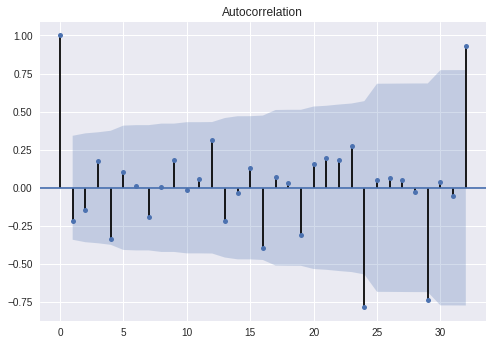

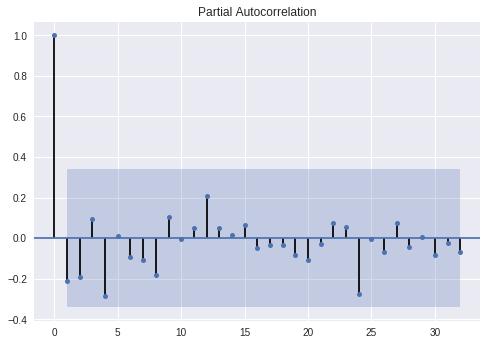

In [0]:
#@title Autocorrelação do resíduo:

plot_acf(fitted.resid, unbiased=True)
plot_pacf(fitted.resid)
plt.show()

In [0]:
step = 3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


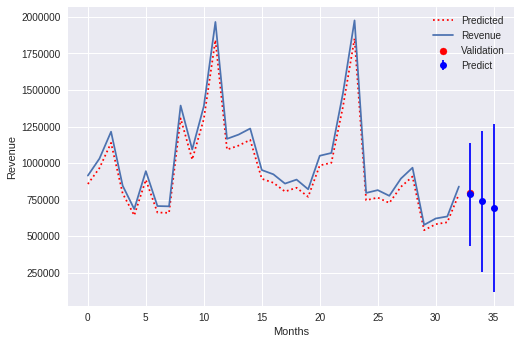

In [0]:
#@title Previsão de n steps:

pred = fitted.forecast(steps=step)
yhat = fitted.predict(start=1, end=len(df))
xplot = df
plt.plot(yhat, label='Predicted', color='r', linestyle=':')
plt.plot(xplot, label='Revenue')
xplot=[len(xplot) + i for i in range(len(pred[0]))]
plt.scatter(x=xplot[0], y=validation, color='r', label='Validation')
plt.errorbar(x=xplot, y=pred[0], yerr=pred[1], fmt='o', color='b', label='Predict')
plt.xlabel('Months')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [0]:
#@title Modulo do erro entre a previsão e o valor esperado:
print(np.abs((validation - pred[0][0])/validation))

0.008540331502182608


# ARIMA

** Escolher $dd = 0$ e $dif = 1$ é o mesmo que fazer $dd = 1$ e $dif = 0$. **



Funciona com: 
* $p=8$, $q=4$, $d=0$, $dif = 1$
* $p=5$, $q=4$, $d=0$, $dif = 6$
* $p=2$, $q=2$, $d=0$, $dif = 12$
* $p=5$, $q=0$, $d=0$, $dif = 1$, css-mle, nc
* $p=1$, $q=0$, $d=0$, $dif = 1$, css-mle, nc (best fit)

In [0]:
pp = 1
qq = 0
dd = 0
dif = 1

In [0]:
#@title Run ARIMA
df1 = month['revenue'].diff(dif)[dif:].values[:-1]
validation1 = month['revenue'].diff(dif)[dif:].values[-1]
model1 = smt.ARIMA(df1, order=(pp, dd, qq))
fitted1 = model1.fit(method='css-mle', trend='nc')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [0]:
#@title ARIMA summary:
print(fitted1.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


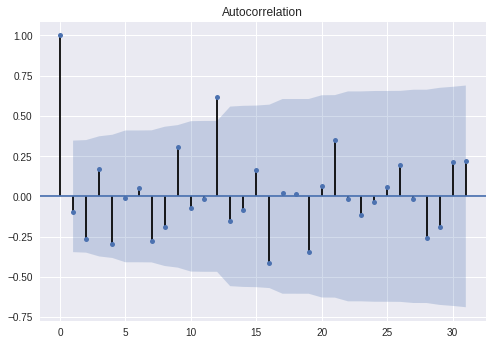

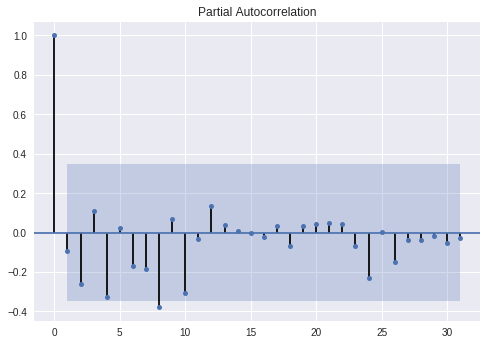

In [0]:
#@title Autocorrelação do resíduo:

plot_acf(fitted1.resid, unbiased=True)
plot_pacf(fitted1.resid)
plt.show()

In [0]:
step = 3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


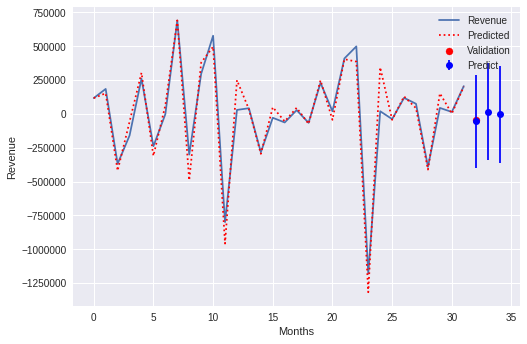

In [0]:
#@title Previsão de n steps:

pred = fitted1.forecast(steps=step)
yhat = fitted1.predict(start=0, end=len(df1)-1)
xplot = df1
plt.plot(xplot, label='Revenue')
plt.plot(yhat + xplot, label='Predicted', color='r', linestyle=':')
xplot=[len(xplot) + i for i in range(len(pred[0]))]
plt.scatter(x=xplot[0], y=validation1, color='r', label='Validation')
plt.errorbar(x=xplot, y=pred[0], yerr=pred[1], fmt='o', color='b', label='Predict')
plt.xlabel('Months')
plt.ylabel('Revenue')
plt.legend()
plt.show()

In [0]:
#@title Modulo do erro entre a previsão e o valor esperado:
print(np.abs((validation1 - pred1[0][0])/validation1))

NameError: ignored

# SARIMA

* P: Seasonal autoregressive order.
* D: Seasonal difference order.
* Q: Seasonal moving average order.
* m: The number of time steps for a single seasonal period

In [0]:
p1 = 1
d1 = 0
q1 = 0
P = 1
D = 0
Q = 0
m = 0
dif1 = 1

In [0]:
#@title Run SARIMA
df2 = month['revenue'].diff(dif1)[dif1:].values[:-1]
validation2 = month['revenue'].diff(dif1)[dif1:].values[-1]

model2 = smt.SARIMAX(df2, order=(q1, d1, q1), seasonal_order=(P, D, Q, m))

start_param = np.zeros(len(model2.param_names))
start_param[-1] = 1

fitted2 = model2.fit(start_params=start_param, method='powell')

Optimization terminated successfully.
         Current function value: 14.171599
         Iterations: 2
         Function evaluations: 105


In [0]:
#@title SARIMA summary:
print(fitted2.summary())

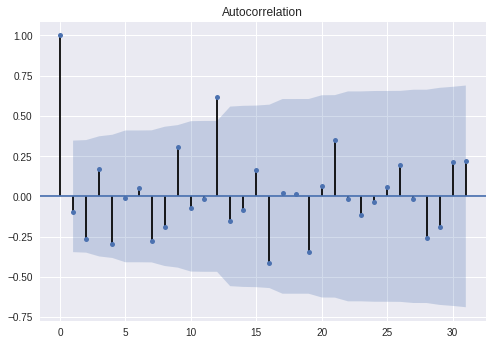

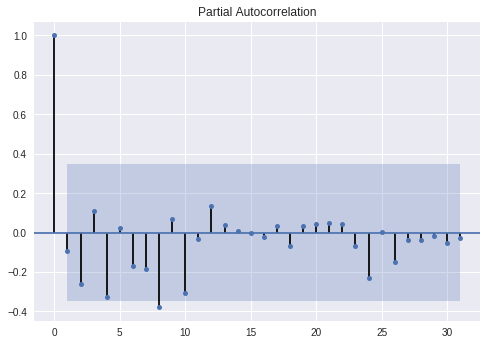

In [0]:
#@title Autocorrelação do resíduo:

plot_acf(fitted2.resid, unbiased=True)
plot_pacf(fitted2.resid)
plt.show()

In [0]:
step = 3

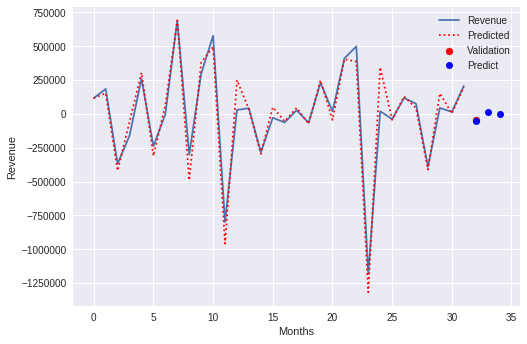

In [0]:
#@title Previsão de n steps:

pred2 = fitted2.forecast(steps=step)
yhat = fitted2.predict(start=0, end=len(df2)-1)
xplot = df2
plt.plot(xplot, label='Revenue')
plt.plot(yhat + xplot, label='Predicted', color='r', linestyle=':')
xplot=[len(xplot) + i for i in range(len(pred2))]
plt.scatter(x=xplot[0], y=validation2, color='r', label='Validation')
plt.errorbar(x=xplot, y=pred2, fmt='o', color='b', label='Predict')
plt.xlabel('Months')
plt.ylabel('Revenue')
plt.legend()

plt.show()

In [0]:
#@title Modulo do erro entre a previsão e o valor esperado:
print(np.abs((validation2 - pred2[0])/validation2))

0.22441062580447613


# XGboost

* Sites com contéudo sobre o XGboost:
- [Repo do Git](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions)
- [Site com um monte de ref](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning)
- [Documentação](https://xgboost.readthedocs.io/en/latest/)

In [0]:
#@title Dado um shopping (shop_id), temos a quantidade de um item (item_id) vendido no mês (date_block_num)
train_month = train_full.pivot_table(index=['shop_id', 'item_id'], columns=['date_block_num'],
                                     values='item_cnt_day', aggfunc=np.sum, fill_value=0.0)

train_month.head()

date_block_num   0   1   2   3   4   5   6   7   8   9  ...  24  25  26  27  \
shop_id item_id                                         ...                   
0       30        0  31   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0 ...   0   0   0   0   

date_block_num   28  29  30  31  32  33  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  

[5 rows x 34 columns]

In [0]:
train_month = train_month.reset_index()
train_month.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
#@title Xgboost Parameters
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':10, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

train_matrix1 = xgb.DMatrix(train_month.iloc[:,  2:35].values, train_month.iloc[:, (train_month.columns != 33)].values)
test_matrix1 = xgb.DMatrix(train_month.iloc[:, (train_month.columns != 33)].values)

bst1 = xgb.train(param, train_matrix1)

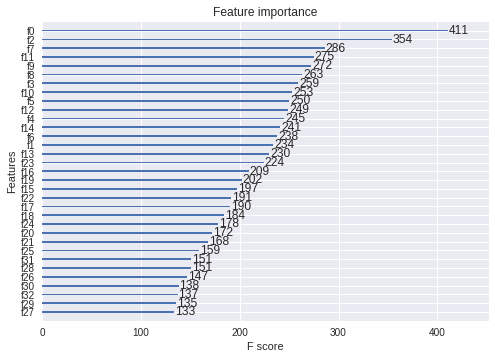

In [0]:
#@title Dropando as colunas shop_id e item_id.
xgb.plot_importance(bst1, importance_type='weight')
plt.show()

* As features tem uma escala melhor e os meses mais relevantes são:
 * Janeiro, Março, Julho, Novembro, Outrubro, Agosto, Abril, Outubro, Maio
* Não parece identifcar nenhum tipo de fériado, tipo o Natal.

In [0]:
#@title 
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':10, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

train_matrix = xgb.DMatrix(train_month.iloc[:,  (train_month.columns != 33)].values, train_month.iloc[:, train_month.columns == 33].values)
test_matrix = xgb.DMatrix(train_month.iloc[:, train_month.columns == 33].values)

bst = xgb.train(param, train_matrix)

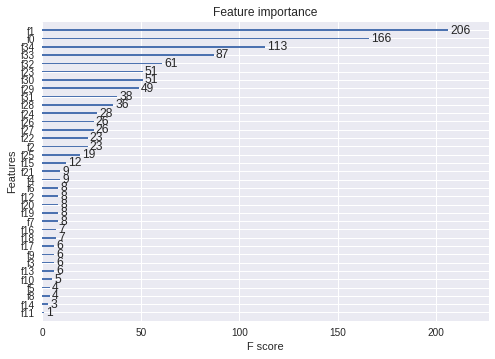

In [0]:
#@title Considerando todas as colunas.
xgb.plot_importance(bst, importance_type='weight')
plt.show()

* As colunas mais importantes são shop_id e item_id. Nenhuma informação nova.

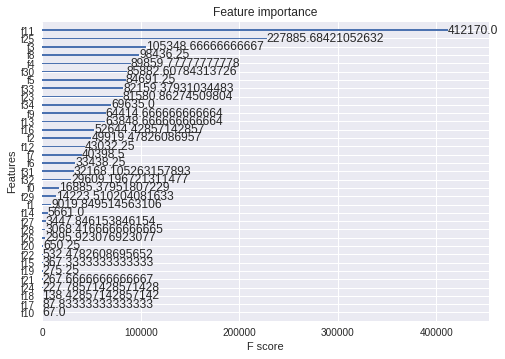

In [0]:
#@title 
xgb.plot_importance(bst, importance_type='cover')
plt.show()

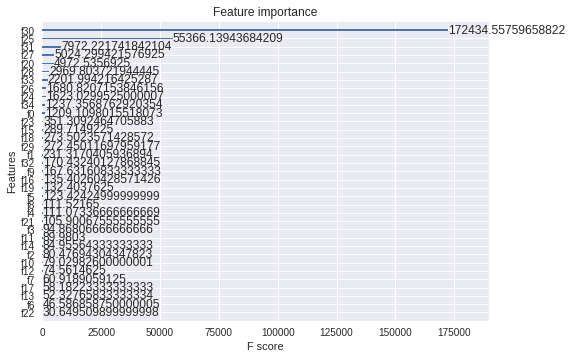

In [0]:
#@title
xgb.plot_importance(bst, importance_type='gain')
plt.show()

In [0]:
from graphviz import Digraph
xgb.to_graphviz(bst, num_trees=1,)

# PCA

* É sensível a escala das variáveis.
* Tem problemas com outliers.
* Não é bom com um data_set muito grande. (SparcePCA)
* Para correlações não lineares usar o KernelPCA.
* ICA is not used for reducing dimensionality but for separating superimposed signals.
* LDA tries to identify attributes that account for the most variance between classes

* ** To do: **
 * KernelPCA
 * LDA
 * ICA

In [0]:
train_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [0]:
X = train_full.drop(['date', 'item_name', 'item_category_name', 'shop_name'], axis=1)
X = X.pivot_table(index=['shop_id', 'item_category_id'],
                                      values='item_cnt_day', aggfunc=np.sum, fill_value=0.0)
X = X.reset_index()
X.head()


,shop_id,item_category_id,item_cnt_day
0,0,0,1
1,0,1,1
2,0,2,105
3,0,3,52
4,0,4,38


In [0]:
X.describe()

,shop_id,item_category_id,item_cnt_day
count,3271.000000,3271.000000,3271.000000
mean,29.763987,41.077346,1115.318251
std,17.266164,24.174793,3221.940260
min,0.000000,0.000000,1.000000
25%,15.000000,20.000000,45.000000
50%,30.000000,40.000000,206.000000
75%,45.000000,63.000000,717.500000
max,59.000000,83.000000,76069.000000


In [0]:
scaler = StandardScaler().fit(X) # salva a média e std de cada coluna, para poder ser aplicado no set de treino.
X_stand = scaler.transform(X)
print('\nMean:', scaler.mean_, '\n\nStd:', scaler.scale_)


Mean: [  29.76398655   41.07734638 1115.3182513 ] 

Std: [  17.26352475   24.17109749 3221.44772118]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [0]:
#@title Dataframe centrado em zero com variância 1.
pd.DataFrame(X_stand, columns=X.columns).describe()

,shop_id,item_category_id,item_cnt_day
count,3.271000e+03,3.271000e+03,3.271000e+03
mean,6.408135e-17,-6.571054e-17,-1.495118e-17
std,1.000153e+00,1.000153e+00,1.000153e+00
min,-1.724097e+00,-1.699441e+00,-3.459060e-01
25%,-8.552128e-01,-8.720062e-01,-3.322476e-01
50%,1.367122e-02,-4.457168e-02,-2.822701e-01
75%,8.825552e-01,9.069780e-01,-1.234905e-01
max,1.693514e+00,1.734412e+00,2.326708e+01


In [0]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_stand)
principalDf = pd.DataFrame(data = principalComponents)

In [0]:
pca.explained_variance_ratio_

array([0.35424145, 0.33288992, 0.31286863])

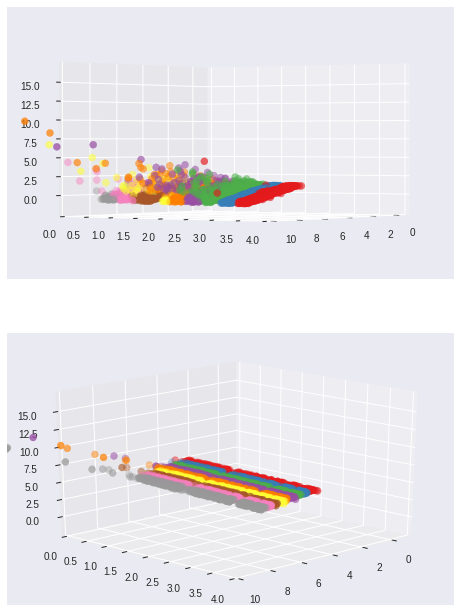

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,11))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(xs=principalDf[0], ys=principalDf[1], zs=principalDf[2], c=X['item_category_id'], s=50, cmap='Set1')
ax.view_init(0, 35)
plt.xlim(-1, 10)
plt.ylim(0, 4)

ax1 = fig.add_subplot(212, projection='3d')
ax1.scatter(xs=principalDf[0], ys=principalDf[1], zs=principalDf[2], c=X['shop_id'], s=50, cmap='Set1')
ax1.view_init(20, 45)
plt.xlim(-1, 10)
plt.ylim(0, 4)

plt.show()

# Xgboost with lagged (shifted) variables ------ (fiz as colunas erradas)

- Organizar a matriz de entrada.
- Aplicar o clip(0, 20).
- Fazer o shift. (Não sei se é pra deixar os zeros ou deslocar pra trás as variáveis)
- Usar o Xgboost
- Brincar com outras variáveis. (ARIMA)
https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [0]:
df_month = train_cleaned.pivot_table(index=['shop_id', 'item_id'], columns=['date_block_num'], values=['item_cnt_day'], aggfunc=np.sum, fill_value=0).astype('int16').head()
df_month.head()

item_cnt_day                             ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9  ... 24 25 26 27 28   
shop_id item_id                                          ...                  
0       30                 0  31  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

In [0]:
df_month = df_month.clip(0,20)
df_month

item_cnt_day                             ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9  ... 24 25 26 27 28   
shop_id item_id                                          ...                  
0       30                 0  20  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

In [0]:
df_month.columns = df_month.columns.droplevel(0)

In [0]:
df_month.reset_index()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,30,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
df_month[34] = 0
df_month.head()

date_block_num   0   1   2   3   4   5   6   7   8   9  ...  25  26  27  28  \
shop_id item_id                                         ...                   
0       30        0  20   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0 ...   0   0   0   0   

date_block_num   29  30  31  32  33  34  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  

[5 rows x 35 columns]

In [0]:
df_lag1 = df_month.shift(periods=1, axis='columns').fillna(0).head()
df_lag3 = df_month.shift(periods=3, axis='columns').fillna(0).head()
df_lag6 = df_month.shift(periods=6, axis='columns').fillna(0).head()
df_lag9 = df_month.shift(periods=9, axis='columns').fillna(0).head()
df_lag12 = df_month.shift(periods=12, axis='columns').fillna(0).head()

In [0]:
df_month.index.droplevel(1)
df_month.head()

date_block_num   0   1   2   3   4   5   6   7   8   9  ...  25  26  27  28  \
shop_id item_id                                         ...                   
0       30        0  20   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0 ...   0   0   0   0   

date_block_num   29  30  31  32  33  34  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  

[5 rows x 35 columns]

In [0]:
df_month_merged = pd.merge(test, df_month.reset_index(), on=['shop_id', 'item_id'], how='left').fillna(0)
df_month_merged.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Xgboost o retorno

- É possível que 

https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [22]:
print('Número itens de diferentes entre Train e Test: ', len(set(test.item_id) - set(test.item_id).intersection(set(train_cleaned.item_id))))

Número itens de diferentes entre Train e Test:  363


Para fazer o set de train mais parecido com o de test, vamos criar um dataset novo onde teremos para cada mês e shopping id todos os itens_id's, mesmo que eles não tenham venda.

In [23]:
n_months = train_cleaned['date_block_num'].nunique()

aux = []

for i in range(n_months):
  
  df = train_cleaned[train_cleaned.date_block_num == i]

  shop_uniq, item_uniq = df.shop_id.unique(), df.item_id.unique()

  a = list(product([i], shop_uniq, item_uniq))
  a = np.array(a)
  aux.append(a)
  
aux = pd.DataFrame(np.vstack(aux), columns=['date_block_num', 'shop_id', 'item_id'])
aux.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [24]:
df_month = train_cleaned
df_month = df_month.groupby(by=['date_block_num', 'shop_id', 'item_id'], axis='index').sum()
df_month.rename(columns={'item_cnt_day':'item_cnt_month', 'revenue':'revenue_month'}, inplace=True)
df_month.reset_index(inplace=True)
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_category_id,revenue_month,city_code,type_code,subtype_code
0,0,0,32,884.0,6.0,160,1326.0,116,44,16
1,0,0,33,1041.0,3.0,111,1041.0,87,33,3
2,0,0,35,247.0,1.0,40,247.0,29,11,4
3,0,0,43,221.0,1.0,40,221.0,29,11,4
4,0,0,51,257.0,2.0,114,257.0,58,26,16


In [25]:
df_month = pd.merge(aux, df_month, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0).clip(0, 20)

In [26]:
test['date_block_num'] = 34
test.drop(['ID'], axis='columns', inplace=True)
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [27]:
#@title Adicionando o test set como o último mês
df_month = pd.concat([df_month, test], ignore_index=True, keys=['date_block_num', 'shop_id', 'item_id']).fillna(0)
df_month.tail()

/home/ronaldo/anaconda3/envs/Data_Science/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,city_code,date_block_num,item_category_id,item_cnt_month,item_id,item_price,revenue_month,shop_id,subtype_code,type_code
11128045,0.0,34.0,0.0,0.0,18454.0,0.0,0.0,45.0,0.0,0.0
11128046,0.0,34.0,0.0,0.0,16188.0,0.0,0.0,45.0,0.0,0.0
11128047,0.0,34.0,0.0,0.0,15757.0,0.0,0.0,45.0,0.0,0.0
11128048,0.0,34.0,0.0,0.0,19648.0,0.0,0.0,45.0,0.0,0.0
11128049,0.0,34.0,0.0,0.0,969.0,0.0,0.0,45.0,0.0,0.0


In [28]:
df_lag3 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag6 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag9 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag12 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()

In [29]:
df_lag3.rename(columns={'item_cnt_month':'lag3_item_cnt_month', 'revenue':'lag3_revenue_month'}, inplace=True)
df_lag6.rename(columns={'item_cnt_month':'lag6_item_cnt_month', 'revenue':'lag6_revenue_month'}, inplace=True)
df_lag9.rename(columns={'item_cnt_month':'lag9_item_cnt_month', 'revenue':'lag9_revenue_month'}, inplace=True)
df_lag12.rename(columns={'item_cnt_month':'lag12_item_cnt_month', 'revenue':'lag12_revenue_month'}, inplace=True)

In [30]:
df_lag3['date_block_num'] += 3
df_lag6['date_block_num'] += 6
df_lag9['date_block_num'] += 9
df_lag12['date_block_num'] += 12

In [33]:
df_month.head()

,city_code,date_block_num,item_category_id,item_cnt_month,item_id,item_price,revenue_month,shop_id,subtype_code,type_code
0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
4,20.0,0.0,20.0,6.0,20.0,20.0,20.0,0.0,16.0,20.0


In [31]:
df_xb_train = pd.merge(df_month, df_lag3, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

MemoryError: 

In [ ]:

df_xb_train = pd.merge(df_xb_train, df_lag6, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
df_xb_train = pd.merge(df_xb_train, df_lag9, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
df_xb_train = pd.merge(df_xb_train, df_lag12, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)

In [0]:
df_xb_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day',
       'revenue', 'lag3_item_cnt', 'lag3_revenue', 'lag6_item_cnt',
       'lag6_revenue', 'lag9_item_cnt', 'lag9_revenue', 'lag12_item_cnt',
       'lag12_revenue'],
      dtype='object')

In [0]:
df_xb_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609124 entries, 0 to 1609123
Data columns (total 14 columns):
date_block_num    1609124 non-null int64
shop_id           1609124 non-null int64
item_id           1609124 non-null int64
item_price        1609124 non-null float64
item_cnt_day      1609124 non-null float64
revenue           1609124 non-null float64
lag3_item_cnt     1609124 non-null float64
lag3_revenue      1609124 non-null float64
lag6_item_cnt     1609124 non-null float64
lag6_revenue      1609124 non-null float64
lag9_item_cnt     1609124 non-null float64
lag9_revenue      1609124 non-null float64
lag12_item_cnt    1609124 non-null float64
lag12_revenue     1609124 non-null float64
dtypes: float64(11), int64(3)
memory usage: 184.1 MB


In [0]:
df_xb_train[df_xb_train.date_block_num != 33]

In [0]:
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':10,
         'silent':1,
         'eval_metric':'rmse'}

train = xgb.DMatrix(df_xb_train[df_xb_train.date_block_num != 33].drop(['item_cnt_day'], axis='columns'), df_xb_train[df_xb_train.date_block_num != 33]['item_cnt_day'])
test = xgb.DMatrix(df_xb_train[df_xb_train.date_block_num != 33].values)

bst1 = xgb.train(param, train)

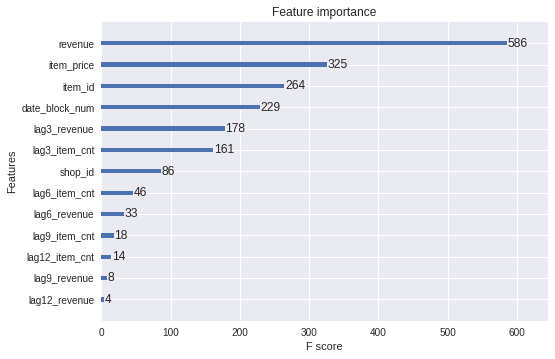

In [0]:
xgb.plot_importance(bst1, importance_type='weight')
plt.show()

In [0]:
from xgboost import XGBRegressor
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3)

X_train = df_xb_train[df_xb_train.date_block_num != 33].drop(['item_cnt_day'], axis='columns')
Y_train = df_xb_train[df_xb_train.date_block_num != 33]['item_cnt_day']

X_valid = df_xb_train[df_xb_train.date_block_num == 33].drop(['item_cnt_day'], axis='columns')
Y_valid = df_xb_train[df_xb_train.date_block_num == 33]['item_cnt_day']

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

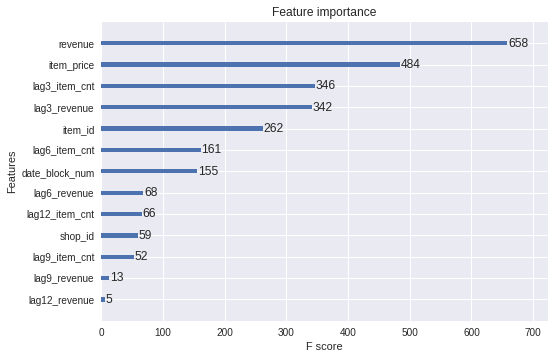

In [0]:
xgb.plot_importance(model, importance_type='weight')
plt.show()

# LSTM

* link [LSTM exemplo](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)
* [Kernel](https://www.kaggle.com/dimitreoliveira/deep-learning-for-time-series-forecasting)

# Olhando para as features

In [0]:
#@title Média dos itens mais vendidos por mês, print dos 10 mais vendidos
df = train_full.groupby(['date_block_num'])
df['item_category_id'].value_counts().groupby(['item_category_id']).sum().nlargest(n=10)

item_category_id
40    564652
30    351591
55    339585
19    208219
37    192674
23    146789
28    121539
20     79058
63     53845
65     53227
Name: item_category_id, dtype: int64

Info:



*   As features com valores numéricos não possuem correlação linear.
*   **Item_price possui uma entrada com valor negativo (Devil May Cry foi de graça?). 484683.**
*   Item_cnt_day possui entradas negativas, provavelmente é uma devolução.
*   São 60 shoppings diferentes com um total de 22170 itens.
*   **Uma compra na linha 1163158 tem um valor muito alto (compra de software para uma empresa).**
*   **Std do item_price é muito alto, está na casa dos 1000.**
*   **Nem todos os shoppins tem vendas até o último ano, parece que alguns fecharam.**
*   **Olhar para a transformada de Fourier ou fazer alguma análise temporal. (Tem pacote pra isso)**
*  **Poucos itens tem um preço maior do queu 30.000, pouco mais do que 300 itens. (descartar?)**
* ** Adicionar a coluna revenue (item_price * item_cnt_day)**
* ** Usar kNN para agrupar categorias, shoppings e talz.**
* ** Adicionar as features algo relacionado as categorias:** Relação com as mais vendidas, unidades vendidas dessa categoria, valor vendido nessa categoria, valor médio das vendas nessa categoria. 
* ** No nome do shopping tem alguma informação sobre a localização. **
* ** Tirar outliers para usar o PCA. **

To do:

* Aplicar xgboost. [Kernel com XGboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
* Dividir os sets de treino, dev e test.


# Input



*   Nem todos os itens que estão no treino vão estar no teste.
*   Nem todos os shoppings estarão no treino.
*   **Não sei se dropar os que não estão no treino é uma boa ideia.**



In [0]:
test_set = pd.read_csv(path + '/test.csv.gz')
test_set.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [0]:
test_set.drop(['ID'], axis=1, inplace=True)

In [0]:
print('Número de itens no teste:', test_set['shop_id'].nunique())
print('Número de shoppings no teste:', test_set['item_id'].nunique())
print('Número de itens no treino:', train_full['shop_id'].nunique())
print('Número de shoppings no treino:', train_full['item_id'].nunique())

Número de itens no teste: 42
Número de shoppings no teste: 5100
Número de itens no treino: 60
Número de shoppings no treino: 21806


In [0]:
x = train_full[['date_block_num','item_id','shop_id','item_cnt_day']].groupby(['date_block_num','shop_id','item_id']).mean().reset_index()
x.head()

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,1.5
1,0,0,33,1.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,1.0


In [0]:
x = x.pivot_table(index=['item_id','shop_id'], columns='date_block_num',values='item_cnt_day',fill_value=0).reset_index()
x.head()

date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
x = pd.merge(test_set, x, on=['item_id','shop_id'], how='left')
x = x.fillna(0)
x.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
x.columns = ['shop_id', 'item_id'] + [str(x) for x in range(34)] 

In [0]:
Y_train = x[['shop_id', 'item_id', '33']]
Y_train.head()


,shop_id,item_id,33
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0


In [0]:
X_train = x.loc[:, 'shop_id':'32']
X_train.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,32
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
print(train_full.shape)
print(x.shape)
print(test_set.shape)

(2935847, 10)
(214200, 36)
(214200, 2)


# Usando LSTM com o Keras

Quais vão ser os inputs/outputs do modelo?



*   O output ($y_{out}$) vai ser o número de itens vendidos no mês para cada shopping.
*   O input para cada amostra (cada shopping) vai ser item_cnt_month * item_price.




In [0]:
print(X_train.shape)
print(Y_train.shape)

(214200, 35)
(214200, 3)


In [0]:
Y = Y_train
X = X_train

In [0]:
Y = Y_train.drop(['shop_id', 'item_id'], axis=1)
X = X_train.drop(['shop_id', 'item_id'], axis=1)

In [0]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.5,1.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X = X.values.reshape((X.shape[0], X.shape[1],  1))
#Y = Y.values.reshape((Y.shape[0], Y.shape[1], 1))
Y = Y

In [0]:
print(X.shape)
print(Y.shape)

(214200, 33, 1)
(214200, 1)


In [0]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X, Y, batch_size = 4096, epochs = 10)

Epoch 1/10
214200/214200 [==============================] - 9s 42us/step - loss: 1.3782 - mean_squared_error: 1.3782
Epoch 2/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3655 - mean_squared_error: 1.3655
Epoch 3/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3612 - mean_squared_error: 1.3612
Epoch 4/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3567 - mean_squared_error: 1.3567
Epoch 5/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3564 - mean_squared_error: 1.3564
Epoch 6/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3543 - mean_squared_error: 1.3543
Epoch 7/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3436 - mean_squared_error: 1.3436
Epoch 8/10
214200/214200 [==============================] - 6s 29us/step - loss: 1.3383 - mean_squared_error: 1.3383
Epoch 9/10
214200/214200 [==============================] - 6s 2

In [0]:
# creating submission file 
t = pd.read_csv(path + '/test.csv.gz')
submission_pfs = model.predict(X)
# we will keep every value between 0 and 20
submission_pfs = submission_pfs.clip(0,20)
# creating dataframe with required columns 
submission = pd.DataFrame({'ID':t['ID'],'item_cnt_month':submission_pfs.ravel()})
# creating csv file from dataframe
submission.to_csv('sub_pfs.csv',index = False)

In [0]:
print(submission.head())

   ID  item_cnt_month
0   0        0.561491
1   1        0.078426
2   2        0.496297
3   3        0.201618
4   4        0.078426
